In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

#from nltk.corpus import stopwords
# preprocess words
import nltk
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.externals import joblib
from gensim.models.keyedvectors import KeyedVectors

import time

from keras.layers import Input, Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional, MaxPooling1D, Conv1D, Flatten, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
import h5py


# model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.utils import compute_class_weight

from sklearn.preprocessing import LabelEncoder


# snippet of using the ReduceLROnPlateau callback
from keras.callbacks import ReduceLROnPlateau
# import these modules
from nltk.stem import WordNetLemmatizer
# split into words
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
header_list = ["asin", "overall", "reviewtext", "category"]
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/for_nlp_models.csv', names = header_list)

In [4]:
df = df.dropna(subset=['reviewtext'])

Text(0, 0.5, 'Count')

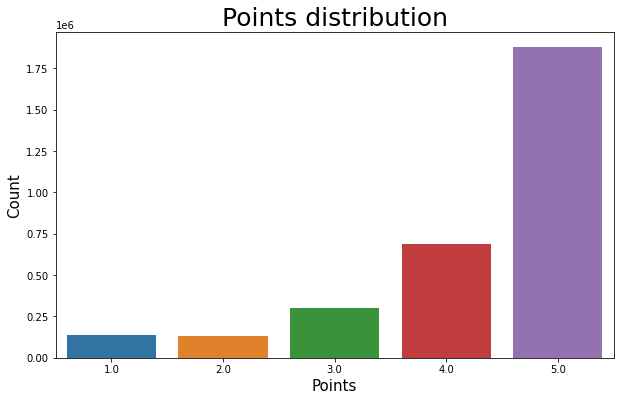

In [ ]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [5]:
lab_vals = [1, 2, 3, 4, 5]
new_lab_vals = [0, 0, 1, 2, 2]

di_map = dict(zip(lab_vals, new_lab_vals))

di_map = dict(zip(lab_vals, new_lab_vals))
df['overall'] = df['overall'].map(di_map)

Text(0, 0.5, 'Count')

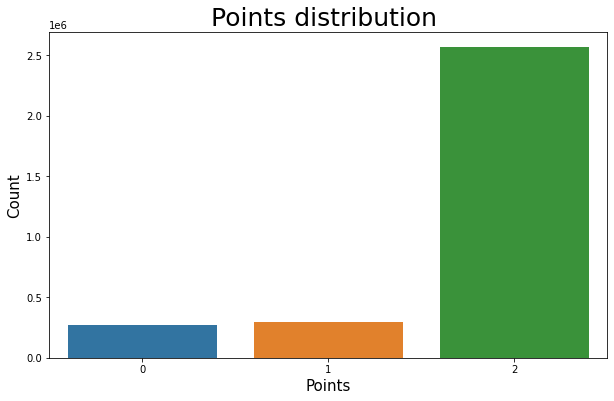

In [ ]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution ", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [6]:
df['reviewtext'] = df['reviewtext'].str.lower()

In [ ]:
# Reviews (feature Description in the dataset) - correlation of the length of the review with the rating

In [ ]:
desc_length = df['reviewtext'].apply(len)

print(f"The longest description contains: {desc_length.max()} characters")
print(f"The shortest description contains: {desc_length.min()} characters")
print(f"Median number of characters is: {desc_length.median()}")
print(f"Standard deviation of reviews: {np.std(desc_length)}")

The longest description contains: 8866 characters
The shortest description contains: 1 characters
Median number of characters is: 142.0
Standard deviation of reviews: 205.11215939297492


In [ ]:
df = df.assign(desc_length = df['reviewtext'].apply(len))

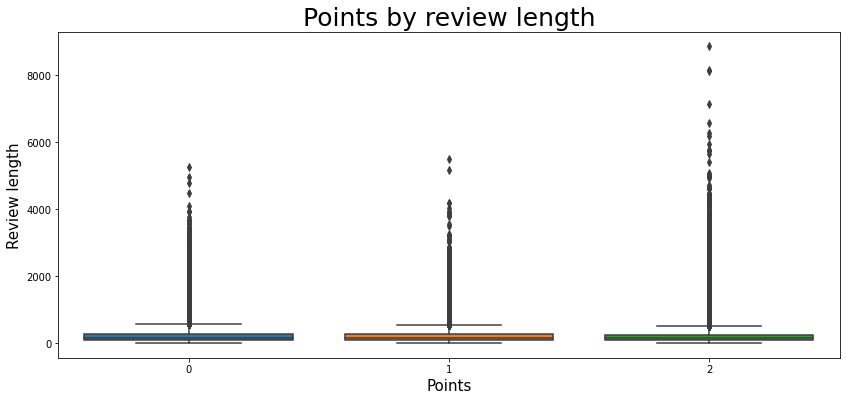

In [ ]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
plt.show()

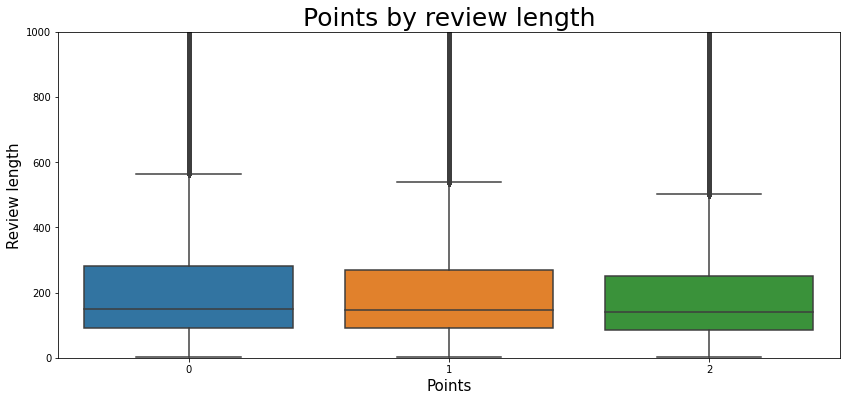

In [ ]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
points_length.set_ylim([0,1000])
plt.show()

In [ ]:
# interestingly there is no correlation of the length of the review and the rating assigned

In [ ]:
# this dataset is rather large - take a random sample of the wordcloud, hence going forward, I will take
# a sample of the dataset

In [7]:
df2 = df.sample(n = 5000, random_state=42)
#df2 = df

In [ ]:
# WordCloud of reviews shows most common words in reviews excluding stopwords.

In [ ]:
# stopwords = set(STOPWORDS)
# newStopWords = ["book", "read", "story", "character", "read", "series", "time", "reading", "author"]
# stopwords.update(newStopWords)

In [ ]:
# wordcloud = WordCloud(
#     background_color='white',
#     stopwords=stopwords,
#     max_words=300,
#     max_font_size=100, 
#     width=1000, height=800,
#     random_state=42,
# ).generate(" ".join(df2['reviewtext']))

# print(wordcloud)
# fig = plt.figure(figsize = (12,14))
# plt.imshow(wordcloud)
# plt.title("WordCloud - Kindle Reviews",fontsize=25)
# plt.axis('off')
# plt.show()

# Train Test Split

In [ ]:
# Some Preprocessing

In [8]:
# 3.step: removing the stopwords
stopwords_1 = STOPWORDS

In [ ]:
# no_list = ['no', 'nor', 'not']

In [ ]:
# keep_stops = [e for e in stopwords_1 if e.endswith("n't")] + [e for e in stopwords_1 if e.endswith("n'")]\
#                 + [e for e in stopwords_1 if e.endswith("n") and len(e)>=4] + no_list

In [9]:
#stopwords = set(list(set(stopwords_1) - set(keep_stops)))
stopwords = set(stopwords_1) 

In [10]:
df2.reviewtext = df2.reviewtext.map(lambda x: word_tokenize(x))

# ps = PorterStemmer()
# df2['stemmed'] = df2.reviewtext.apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.

lemmatizer = WordNetLemmatizer()
df2['reviewtext'] = df2['reviewtext'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x]) # Stem every word.

In [11]:
def remove_stopwords (df, colname, stopwords = stopwords):

    #split words / tokenise
    #df[colname] = list(map(lambda x: x.lower().split(), df[colname]))
    #df[colname] = list(map(lambda x: word_tokenize(x), df[colname]))

    #lemmatise
    #df[colname] = list(map(lambda line: list(map(lambda word: lemmatizer.lemmatize(word), line)), df[colname]))

    #remove stopwords
    df[colname] = list(map(lambda line: list(filter(lambda word: word not in stopwords, line)), df[colname]))

    #join back to 'full sentence' form
    df[colname] = list(map(lambda x: " ".join(x), df[colname]))
    
    return df

In [12]:
df2 = remove_stopwords(df = df2, colname = 'reviewtext')

In [13]:
X = df2[["reviewtext", "category"]]
y = df2["overall"]
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=random_state, stratify = y, shuffle = True)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
#                                                           random_state=random_state)

# Text preprocessing





In [14]:
# tokenizing and filtering out basic punctuation and setting to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.reviewtext)

In [15]:
# dictionary mapping words (str) to their index (int)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 10157 unique tokens.


In [17]:
vocab_size = len(word_index)+1

In [16]:
# turning texts into sequences (list of word indexes)
sequences_train = tokenizer.texts_to_sequences(X_train.reviewtext)
sequences_test = tokenizer.texts_to_sequences(X_test.reviewtext)

In [ ]:
# checking the length of the longest review
max_len = max([len(x) for x in sequences_train+sequences_test])
print(f"The longest description has {max_len} words.")

The longest description has 288 words.


In [ ]:
# padding sequences so that they are of equal length
X_train_nn = sequence.pad_sequences(sequences_train, maxlen = max_len)
X_test_nn = sequence.pad_sequences(sequences_test, maxlen = max_len)

In [ ]:
## turning y into one-hots
nb_classes = len(y_train.unique()) # equal to a number of labels
y_train_nn = np_utils.to_categorical(y_train, nb_classes)
y_test_nn = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [ ]:
#!unzip glove.42B.300d.zip

In [ ]:
#  def load_glove_model(glove_input_file, word2vec_output_file="/content/drive/MyDrive/Colab Notebooks/gensim_glove_vectors.txt"):
#      glove2word2vec(glove_input_file, word2vec_output_file)
#      return KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
start_time = time.time()
print(datetime.fromtimestamp(start_time))

#glove_model = load_glove_model("/content/drive/MyDrive/Colab Notebooks/glove.42B.300d.txt")

#glove_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/gensim_glove_vectors.txt", binary=False)
#glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

2021-06-04 14:25:08.349988
--- 1.792112986246745e-05 minutes ---


In [ ]:
vocab_size = len(word_index)+1

10158

In [ ]:
# code to download, unzip, preprocess and load pre-trained Glove model with embeddings



start_time = time.time()
print(start_time)
input_dim = len(word_index)+1 # This is the size of the vocabulary in the text data.
output_dim = 300 # This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
#output_dim = int(3/5*max_len)
# creating embedding matrix containing only embeddings for words used in reviewtext

emb_matrix = np.zeros((input_dim, output_dim))
for w, i in word_index.items():
  try:
    vect = glove_model[w]
    if vect is not None:
      emb_matrix[i] = vect
  except:
    pass


joblib.dump(emb_matrix, "emb_matrix.joblib")
print("--- %s seconds ---" % (time.time() - start_time))

1622816709.0435793
--- 0.10265135765075684 seconds ---


In [ ]:
# checking how many words from reviews are reprezented in pre-trained Glove Embeddings
print(len(([key for key in word_index.keys() if key in glove_model]))/len(word_index))

0.9721374421581176


In [ ]:
#### Preprocessing of the category feature and reviewtext for the wide model

In [ ]:
# reviewtext feature
description_bow_train = tokenizer.texts_to_matrix(X_train.reviewtext)
description_bow_test = tokenizer.texts_to_matrix(X_test.reviewtext)

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
category_train = X_train.category.astype(str)
category_test = X_test.category.astype(str)
encoder.fit(category_train)
category_train = encoder.transform(category_train)
category_test = encoder.transform(category_test)
num_levels = np.max(category_train) + 1

# Convert labels to one hot
category_train = to_categorical(category_train, num_levels)
category_test = to_categorical(category_test, num_levels)

In [ ]:
reviewtext_train = X_train_nn
reviewtext_test = X_test_nn

In [ ]:
X_train_nn = [description_bow_train, category_train] + [reviewtext_train]
X_test_nn = [description_bow_test, category_test] + [reviewtext_test]


### Training the model

In [ ]:
class_weights_numpy = compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

keys_cl_weights = np.unique(y_train).tolist()
values_cl_weights = class_weights_numpy.tolist()
class_weights = dict(zip(keys_cl_weights, values_cl_weights))

In [ ]:
def build_model(list_of_layers):

    # wide model (for simplicity just one model tried)
    bow_inputs = Input(shape=(vocab_size,))
    category_inputs = Input(shape=(num_levels,))
    y = concatenate([bow_inputs, category_inputs])
    y = Dense(256, activation='relu')(y)
    y = Dense(nb_classes, activation = "softmax")(y)
    wide_model = Model(inputs=[bow_inputs, category_inputs], outputs=y)

    wide_model.compile(loss='categorical_crossentropy', 
                       optimizer='adam', 
                       metrics=['categorical_accuracy'])

    # deep model
    reviewtext_inputs = Input(shape = (max_len,))

    x = Embedding(input_dim = emb_matrix.shape[0], 
                  output_dim = emb_matrix.shape[1], 
                  input_length = max_len, #This is the length of input sequences
                  weights = [emb_matrix], 
                  trainable = False)(reviewtext_inputs)

    
    for layer in list_of_layers:
        x = layer(x)
        
    deep_model = Model(inputs = reviewtext_inputs, outputs = x)  
    deep_model.summary()

    deep_model.compile(loss = "categorical_crossentropy", 
                  optimizer = "adam", 
                  metrics = ["categorical_accuracy"])
    
    # combine wide and deep models
    merged_out = concatenate([wide_model.output, deep_model.output])
    merged_out = Dense(nb_classes, activation = "softmax")(merged_out)
    model = Model(wide_model.input + [deep_model.input], merged_out)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                           optimizer='adam', 
                           metrics=['categorical_accuracy'])
    
    #model = load_model(str(filename)+".h5py")

    return model

In [ ]:
def evaluate_model(model, X_train, X_val, y_train, y_val, filename, batch_size=128):

    ext = ".h5py"# ".ckpt" # ".h5py"

    import tensorflow as tf

    rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=1E-7, cooldown = 1, verbose = 1)
    early_stopping = EarlyStopping(patience=5, monitor="val_loss")
    take_best_model = ModelCheckpoint(str(filename)+ext, monitor = "val_loss", verbose = 1, save_best_only=True)

    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2,
              batch_size=batch_size, 
              callbacks=[rlrp, early_stopping, take_best_model], class_weight = class_weights)
    
    model = load_model(str(filename)+ext)
    
    # predict probabilities for test set
    y_prob = model.predict(X_val, verbose=0)
    
    # predict crisp classes for test set
    y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)

    # accuracy: (tp + tn) / (p + n)
    acc = accuracy_score(y_val, y_pred)  
    # precision tp / (tp + fp) # a lot of false positives - lowers precision of the model
    precision = precision_score(y_val, y_pred, average='weighted')
    #print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_val, y_pred, average='weighted')
    #print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val, y_pred, average='weighted')
    #print('F1 score: %f' % f1)
    
    return acc, precision, recall, f1

In [ ]:
models = {  
          # "clf_LSTM_500n":      
          #                       [LSTM(500),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
           
          # "clf_BiLSTM_500n":      
          #                       [Bidirectional(LSTM(500)),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],    
            
          # "clf_LSTM_500n_MultipleDense":      
          #                       [LSTM(500),
          #                        Dropout(0.5),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
    
          # "clf_BiLSTM_500n_MultipleDense":      
          #                       [Bidirectional(LSTM(500)),
          #                        Dropout(0.5),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
          
          # "clf_CNN1D_500n_BiLSTM_MultipleDense":      
          #                       [Conv1D(32, kernel_size=2, padding='valid', input_shape=(1000, 1)),
          #                        MaxPooling1D(pool_size=2),
          #                        Bidirectional(LSTM(500)),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
          
          "clf_BiLSTM_500n_CNN1D_MultipleDense":      
                                [Bidirectional(LSTM(500, return_sequences=True)),
                                 Conv1D(32, kernel_size=3, padding='valid'),
                                 MaxPooling1D(pool_size=2),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Flatten(),
                                 Dense(nb_classes, activation="softmax")]
}



In [ ]:
results_df = pd.DataFrame()

for model_name, layer_params in models.items():
    out = pd.DataFrame([list(evaluate_model(build_model(layer_params), X_train_nn, X_test_nn, y_train_nn, y_test, filename = model_name))], columns = ['accuracy', 'precision', 'recall', 'f1-score'])
    results_df = results_df.append(out)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 288)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 288, 300)          3047400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 288, 1000)         3204000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 286, 32)           96032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 143, 32)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 143, 30)           990       
_________________________________________________________________
dropout_3 (Dropout)          (None, 143, 30)           0   

INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 2/100
27/27 [==============================] - 516s 19s/step - loss: 1.0748 - categorical_accuracy: 0.1206 - val_loss: 1.2772 - val_categorical_accuracy: 0.0988

Epoch 00002: val_loss improved from 1.44219 to 1.27715, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 3/100
27/27 [==============================] - 524s 19s/step - loss: 1.0120 - categorical_accuracy: 0.1466 - val_loss: 1.1597 - val_categorical_accuracy: 0.0859

Epoch 00003: val_loss improved from 1.27715 to 1.15968, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 4/100
27/27 [==============================] - 548s 20s/step - loss: 0.9518 - categorical_accuracy: 0.1416 - val_loss: 1.1381 - val_categorical_accuracy: 0.1012

Epoch 00004: val_loss improved from 1.15968 to 1.13807, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 5/100
27/27 [==============================] - 572s 21s/step - loss: 0.8851 - categorical_accuracy: 0.1584 - val_loss: 1.1940 - val_categorical_accuracy: 0.1047

Epoch 00005: val_loss did not improve from 1.13807
Epoch 6/100
27/27 [==============================] - 547s 20s/step - loss: 0.8735 - categorical_accuracy: 0.1727 - val_loss: 1.1422 - val_categorical_accuracy: 0.1059

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: val_loss did not improve from 1.13807
Epoch 7/100
27/27 [==============================] - 542s 20s/step - loss: 0.8005 - categorical_accuracy: 0.1723 - val_loss: 1.0834 - val_categorical_accuracy: 0.1000

Epoch 00007: val_loss improved from 1.13807 to 1.08336, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 8/100
27/27 [==============================] - 566s 21s/step - loss: 0.7997 - categorical_accuracy: 0.1812 - val_loss: 1.0606 - val_categorical_accuracy: 0.0965

Epoch 00008: val_loss improved from 1.08336 to 1.06061, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 9/100
27/27 [==============================] - 581s 22s/step - loss: 0.7819 - categorical_accuracy: 0.1638 - val_loss: 1.0715 - val_categorical_accuracy: 0.1012

Epoch 00009: val_loss did not improve from 1.06061
Epoch 10/100
27/27 [==============================] - 586s 22s/step - loss: 0.7577 - categorical_accuracy: 0.1672 - val_loss: 1.0600 - val_categorical_accuracy: 0.0988

Epoch 00010: val_loss improved from 1.06061 to 1.06000, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 11/100
27/27 [==============================] - 562s 21s/step - loss: 0.7688 - categorical_accuracy: 0.1753 - val_loss: 1.0480 - val_categorical_accuracy: 0.0988

Epoch 00011: val_loss improved from 1.06000 to 1.04796, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 12/100
27/27 [==============================] - 566s 21s/step - loss: 0.7616 - categorical_accuracy: 0.1776 - val_loss: 1.0514 - val_categorical_accuracy: 0.0988

Epoch 00012: val_loss did not improve from 1.04796
Epoch 13/100
27/27 [==============================] - 569s 21s/step - loss: 0.7545 - categorical_accuracy: 0.1808 - val_loss: 1.0470 - val_categorical_accuracy: 0.1071

Epoch 00013: val_loss improved from 1.04796 to 1.04697, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 14/100
27/27 [==============================] - 577s 21s/step - loss: 0.7600 - categorical_accuracy: 0.1875 - val_loss: 1.0420 - val_categorical_accuracy: 0.1059

Epoch 00014: val_loss improved from 1.04697 to 1.04204, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 15/100
27/27 [==============================] - 554s 21s/step - loss: 0.7426 - categorical_accuracy: 0.1804 - val_loss: 1.0397 - val_categorical_accuracy: 0.1141

Epoch 00015: val_loss improved from 1.04204 to 1.03971, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 16/100
27/27 [==============================] - 554s 21s/step - loss: 0.7291 - categorical_accuracy: 0.1813 - val_loss: 1.0360 - val_categorical_accuracy: 0.1129

Epoch 00016: val_loss improved from 1.03971 to 1.03602, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 17/100
27/27 [==============================] - 603s 22s/step - loss: 0.7297 - categorical_accuracy: 0.1818 - val_loss: 1.0244 - val_categorical_accuracy: 0.1271

Epoch 00017: val_loss improved from 1.03602 to 1.02440, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 18/100
27/27 [==============================] - 580s 22s/step - loss: 0.7191 - categorical_accuracy: 0.1873 - val_loss: 1.0273 - val_categorical_accuracy: 0.1318

Epoch 00018: val_loss did not improve from 1.02440
Epoch 19/100
27/27 [==============================] - 547s 20s/step - loss: 0.7014 - categorical_accuracy: 0.1892 - val_loss: 1.0224 - val_categorical_accuracy: 0.1353

Epoch 00019: val_loss improved from 1.02440 to 1.02242, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 20/100
27/27 [==============================] - 540s 20s/step - loss: 0.7248 - categorical_accuracy: 0.1911 - val_loss: 1.0229 - val_categorical_accuracy: 0.1412

Epoch 00020: val_loss did not improve from 1.02242
Epoch 21/100
27/27 [==============================] - 547s 20s/step - loss: 0.7172 - categorical_accuracy: 0.1908 - val_loss: 1.0260 - val_categorical_accuracy: 0.1376

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00021: val_loss did not improve from 1.02242
Epoch 22/100
27/27 [==============================] - 568s 21s/step - loss: 0.7248 - categorical_accuracy: 0.1956 - val_loss: 1.0045 - val_categorical_accuracy: 0.1494

Epoch 00022: val_loss improved from 1.02242 to 1.00445, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 23/100
27/27 [==============================] - 540s 20s/step - loss: 0.7190 - categorical_accuracy: 0.1919 - val_loss: 1.0109 - val_categorical_accuracy: 0.1447

Epoch 00023: val_loss did not improve from 1.00445
Epoch 24/100
27/27 [==============================] - 535s 20s/step - loss: 0.6990 - categorical_accuracy: 0.1929 - val_loss: 1.0050 - val_categorical_accuracy: 0.1553

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00024: val_loss did not improve from 1.00445
Epoch 25/100
27/27 [==============================] - 558s 21s/step - loss: 0.7019 - categorical_accuracy: 0.1912 - val_loss: 1.0052 - val_categorical_accuracy: 0.1553

Epoch 00025: val_loss did not improve from 1.00445
Epoch 26/100
27/27 [==============================] - 586s 22s/step - loss: 0.7045 - categorical_accuracy: 0.1964 - val_loss: 1.0058 - val_categorical_accuracy: 0.1553

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 0

In [ ]:
results = results_df.copy()
results['model'] = list(models.keys())
results = results.sort_values(by="f1-score", ascending=False).reset_index(drop=True)

In [ ]:
results

,accuracy,precision,recall,f1-score,model
0,0.137333,0.825892,0.137333,0.108997,clf_BiLSTM_500n_CNN1D_MultipleDense


In [ ]:
###test

In [ ]:
### Load previously trained models and evaluate results

In [ ]:
model_winner = load_model("clf_BiLSTM_500n_CNN1D_MultipleDense.h5py")

In [ ]:
# predict probabilities for test set
y_prob = model_winner.predict(X_test_nn)

In [ ]:
# predict crisp classes for test set
y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 56   4   0]
 [ 53  19   1]
 [537  52  28]]


In [ ]:
cm/cm.sum(axis = 1, keepdims = True)

array([[0.93333333, 0.06666667, 0.        ],
       [0.7260274 , 0.26027397, 0.01369863],
       [0.87034036, 0.08427877, 0.04538088]])